In [13]:
import os
os.environ["KERAS_BACKEND"] = "jax"
import keras
from keras import layers
import numpy as np
import xarray as xr
import zarr
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import random
import jax
import tensorflow as tf

os.environ['JAX_PLATFORM_NAME'] = 'gpu'

# Set seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
jax.config.update('jax_enable_x64', True)
jax.random.PRNGKey(SEED)



# Set the working directory
os.chdir('/data/keeling/a/ad87/downscale')

#### Data Handling: Load and Resample Data
We will load the CMIP6 data and the GMFD observational data. We’ll resample the GMFD data to the CMIP6 resolution (e.g., ~100 km) to use as the target during training.



In [48]:
# Load the CMIP6 raw data (predictor variables)
cmip6_data_path = '/data/cristi/a/cristi/downscaled_data/cmip6/raw/zarr/RO_CMIP6_raw/CNRM-ESM2-1/historical/r1i1p1f2/tas/tas_day_CNRM-ESM2-1_historical_r1i1p1f2_gr_1950_2014_rou.zarr'
cmip6_data = xr.open_zarr(cmip6_data_path)

# Load the GMFD reference observational data (target variable)
gmfd_data_path = '/data/keeling/a/cristi/a/downscaled_data/gmfd/ncs/ro'
gmfd_files = [f'{gmfd_data_path}/tas_daily_ro_{year}.nc' for year in range(1950, 2015)]
gmfd_data = xr.open_mfdataset(gmfd_files, combine='by_coords')

# Resample  CMIP6 to GMFD resolution (~25 km)
target_lat = gmfd_data.lat
target_lon = gmfd_data.lon
cmip6_high_res = cmip6_data.interp(lat=target_lat, lon=target_lon, method='cubic', kwargs={"fill_value": "extrapolate"})


# Normalize the data (standardization)
def normalize(data):
    mean = data.mean().compute().item()
    std = data.std().compute().item()
    return (data - mean) / std

cmip6_data_norm = normalize(cmip6_high_res['tas'])
gmfd_data_norm = normalize(gmfd_data['tas'])

# Convert data to NumPy arrays for use in Keras
cmip6_train = cmip6_data_norm.values
gmfd_train = gmfd_data_norm.values

#### Split the data
Train set: The first portion of the time period (e.g., 60-70% of the time series).
Validation set: The next portion of the time series (e.g., the following 15-20% of the time series).
Test set: The final portion of the time series (e.g., the last 15-20%): 

In [161]:

# Reshape data to add the channel dimension
cmip6_train_reshaped = cmip6_train[..., np.newaxis]
gmfd_train_reshaped = gmfd_train[..., np.newaxis]

# Get the total number of time steps
n_samples = cmip6_train_reshaped.shape[0]

# Split indices based on time series order
train_size = int(n_samples * 0.6)  # 60% for training
val_size = int(n_samples * 0.2)    # 20% for validation
test_size = n_samples - train_size - val_size  # Remainder for test


# Split the data while preserving the temporal structure
X_train = cmip6_train_reshaped[:train_size]
y_train = gmfd_train_reshaped[:train_size]

X_val = cmip6_train_reshaped[train_size:train_size + val_size]
y_val = gmfd_train_reshaped[train_size:train_size + val_size]

X_test = cmip6_train_reshaped[train_size + val_size:]
y_test = gmfd_train_reshaped[train_size + val_size:]

print(X_train.shape)
print(y_train.shape)

print(X_val.shape)
print(y_val.shape)

print(X_test.shape)
print(y_test.shape)


(14244, 42, 97, 1)
(14244, 42, 97, 1)
(4748, 42, 97, 1)
(4748, 42, 97, 1)
(4749, 42, 97, 1)
(4749, 42, 97, 1)


#### Build the U-Net


In [181]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def simple_unet(input_shape=(42, 97, 1)):
    """A simple U-Net with cropping to handle dimension mismatches."""

    inputs = keras.Input(shape=input_shape)

    # Encoder
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)

    # Decoder
    up4 = layers.Conv2DTranspose(128, 2, strides=2, padding='same')(conv3)
    
    # Adjust conv2 size to match up4 size
    conv2_cropped = layers.Cropping2D(cropping=((0, 1), (0, 1)))(conv2) # Crop height and width to match up4
    
    concat4 = layers.concatenate([up4, conv2_cropped], axis=3)
    conv4 = layers.Conv2D(128, 3, activation='relu', padding='same')(concat4)
    conv4 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv4)

    up5 = layers.Conv2DTranspose(64, 2, strides=2, padding='same')(conv4)
    
    # Adjust conv1 size to match up5 size
    conv1_cropped = layers.Cropping2D(cropping=((1, 1), (0, 1)))(conv1) # Crop height and width to match up5

    concat5 = layers.concatenate([up5, conv1_cropped], axis=3)
    conv5 = layers.Conv2D(64, 3, activation='relu', padding='same')(concat5)
    conv5 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv5)

    # Output layer
    outputs = layers.Conv2D(1, 1, activation='linear', padding='same')(conv5)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

# Example usage:
input_shape = (42, 97, 1)
model = simple_unet(input_shape)

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Check the model summary
model.summary()

ValueError: A `Concatenate` layer requires inputs with matching shapes except for the concatenation axis. Received: input_shape=[(None, 20, 48, 128), (None, 20, 47, 128)]

#### Train the model

In [176]:

# Training the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,  # Adjust as needed
    batch_size=32,  # Adjust as needed
    verbose=1  # To show the training process
)

# Evaluate the model on the test data
test_loss = model.evaluate(X_test, y_test)
print(f"Test loss: {test_loss}")

TypeError: sub got incompatible shapes for broadcasting: (32, 42, 97, 1), (32, 44, 100, 1).

In [165]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (14244, 42, 97, 1)
y_train shape: (14244, 42, 97, 1)


#### Define the hyperparameter grid and perform tuning

#### Evaluate the model on validation data

149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


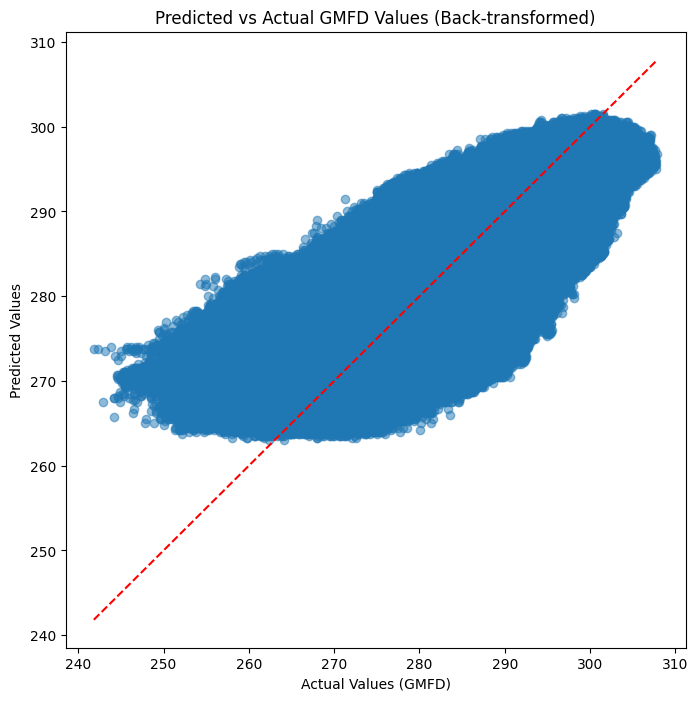

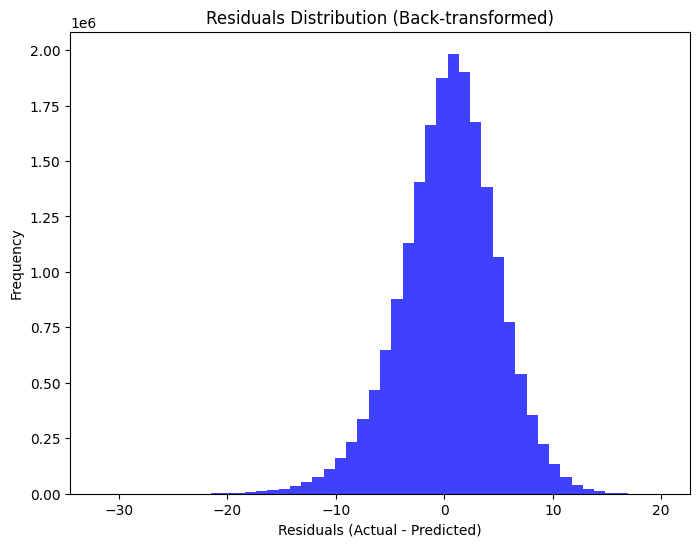

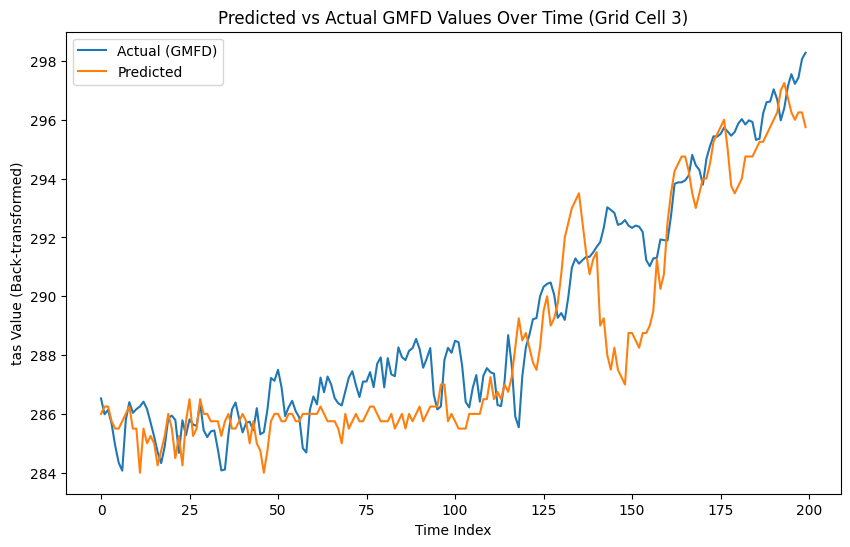

In [116]:
import numpy as np

# Back-transform function
def denormalize(data, mean, std):
    return (data * std) + mean

# Get the mean and std from the training set for denormalization
cmip6_high_res_mean = cmip6_high_res['tas'].mean().values
cmip6_high_res_std = cmip6_high_res['tas'].std().values

# Get the mean and std from the training set for denormalization
gmfd_mean = gmfd_data['tas'].mean().values
gmfd_std = gmfd_data['tas'].std().values

# # Evaluate on the denormalized test data
# val_mse, val_mae = model.evaluate(X_test, y_test, verbose=1)
# print(f"Validation MAE: {val_mae}")
# print(f"Validation MSE: {val_mse}")

# Save the best model
keras.saving.save_model(model, 'models/cnn_encoder_decoder.keras')

# Generate predictions on validation data
y_pred = model.predict(X_val)


# Back-transform the predictions for evaluation
y_val_denorm = denormalize(y_val, cmip6_high_res_mean, cmip6_high_res_std)
y_pred_denorm = denormalize(y_pred, cmip6_high_res_mean, cmip6_high_res_std)

# Plot: Predicted vs Actual Values (back-transformed)
plt.figure(figsize=(8, 8))
plt.scatter(y_val_denorm.flatten(), y_pred_denorm.flatten(), alpha=0.5)
plt.xlabel('Actual Values (GMFD)')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual GMFD Values (Back-transformed)')
plt.plot([y_val_denorm.min(), y_val_denorm.max()], [y_val_denorm.min(), y_val_denorm.max()], 'r--')  # Line of perfect prediction
plt.show()

# Plot: Residuals (Actual - Predicted) after back-transform
residuals_denorm = y_val_denorm.flatten() - y_pred_denorm.flatten()
plt.figure(figsize=(8, 6))
plt.hist(residuals_denorm, bins=50, alpha=0.75, color='blue')
plt.title('Residuals Distribution (Back-transformed)')
plt.xlabel('Residuals (Actual - Predicted)')
plt.ylabel('Frequency')
plt.show()

# Plot: Predicted and Actual Values Over Time for a Specific Grid Cell (Back-transformed)
# Select a grid cell (e.g., the first one)
grid_cell_index = 3
plt.figure(figsize=(10, 6))
plt.plot(y_val_denorm[:200, grid_cell_index, 0].flatten(), label='Actual (GMFD)')
plt.plot(y_pred_denorm[:200, grid_cell_index, 0].flatten(), label='Predicted')
plt.xlabel('Time Index')
plt.ylabel('tas Value (Back-transformed)')
plt.title(f'Predicted vs Actual GMFD Values Over Time (Grid Cell {grid_cell_index})')
plt.legend()
plt.show()


#### Train the Best Model on All Data
Train the model on all the data (no splitting)

Epoch 1/1500
742/742 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.2411 - mae: 0.3769
Epoch 2/1500
742/742 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.2445 - mae: 0.3789
Epoch 3/1500
742/742 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.2416 - mae: 0.3778
Epoch 4/1500
742/742 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.2428 - mae: 0.3782
Epoch 5/1500
742/742 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.2406 - mae: 0.3758
Epoch 6/1500
742/742 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.2376 - mae: 0.3743
Epoch 7/1500
742/742 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.2384 - mae: 0.3744
Epoch 8/1500
742/742 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.2386 - mae: 0.3749
Epoch 9/1500
742/742 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.2369 - mae: 0.3731
Epoch 10/1500
742/742 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.2387 - mae: 0.3752
Epoch 11/1500
742/742 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.2377 - mae: 0.3744
Epoch 12/1500
742/742 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.2358 - mae: 0.3732
E

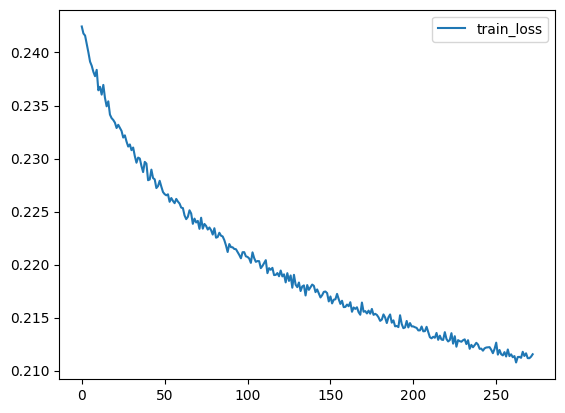

In [91]:
input_shape = (cmip6_train.shape[1], cmip6_train.shape[2], 1)  # Assuming 1 channel (tas)
#model = model(input_shape)
# Define early stopping callback
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

# Train the model on all the data (no splitting)
history = model.fit(
    cmip6_train_reshaped, gmfd_train_reshaped,
    epochs=1500,
    callbacks=[early_stopping],
    verbose=1
)

# Plot the training loss
plt.plot(history.history['loss'], label='train_loss')
plt.legend()
plt.show()

#### Apply the Model to CMIP6 Data to Downscale to GMFD Original Resolution
Now we take the coarse CMIP6 data and downscale it to the original GMFD resolution


In [92]:
# Load the model
from keras.models import load_model
#model = load_model('models/cnn_encoder_decoder.keras')

# Predict downscaled high-resolution data
predicted_high_res = model.predict(cmip6_train_reshaped)

742/742 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


#### Post-process the Predictions

In [93]:
# Inverse transform the predictions to get the actual temperature values


# Get the mean and std from the training set for denormalization
cmip6_high_res_mean = cmip6_high_res['tas'].mean().values
cmip6_high_res_std = cmip6_high_res['tas'].std().values


# Back-transform the predictions and actual values
predicted_high_res_denorm = denormalize(predicted_high_res, cmip6_high_res_mean, cmip6_high_res_std)

# Reshape the predictions to match the original GMFD resolution
predicted_high_res_final = predicted_high_res_denorm.reshape(gmfd_train.shape)

# Save the predictions to a NetCDF file
predicted_ds = xr.DataArray(predicted_high_res_final, dims=gmfd_data.dims, coords=gmfd_data.coords, name='tas_downscaled')
predicted_ds.to_netcdf('/data/keeling/a/ad87/downscale/predicted_high_res_tas_unet.nc')

# #### Results saved to NetCDF format
print("Downscaled high-resolution predictions saved to NetCDF format.")

Downscaled high-resolution predictions saved to NetCDF format.


In [ ]:
# # Check the data structure
predicted_ds['tas'].isel(time=0).plot()
#gmfd_data['tas'].isel(time=0).plot()

#### Test on scenario

In [ ]:
 Load the CMIP6 raw data (predictor variables)
cmip6_scen = '/data/cristi/a/cristi/downscaled_data/gmfd/zarr/gmfd_harm/CNRM-ESM2-1/tas_CNRM-ESM2-1.zarr'
cmip6_data = xr.open_zarr(cmip6_data_path)

# Load the GMFD reference observational data (target variable)
gmfd_data_path = '/data/keeling/a/cristi/a/downscaled_data/gmfd/ncs/ro'
gmfd_files = [f'{gmfd_data_path}/tas_daily_ro_{year}.nc' for year in range(1950, 2015)]
gmfd_data = xr.open_mfdataset(gmfd_files, combine='by_coords')

# Resample GMFD to CMIP6 resolution (~100 km)
target_lat = gmfd_data.lat
target_lon = gmfd_data.lon
cmip6_high_res = cmip6_data.interp(lat=target_lat, lon=target_lon, method='cubic', kwargs={"fill_value": "extrapolate"})

# # Check the data structure
print(cmip6_high_res)
print(gmfd_data)

# Normalize the data (standardization)
def normalize(data):
    mean = data.mean().compute().item()
    std = data.std().compute().item()
    return (data - mean) / std

cmip6_data_norm = normalize(cmip6_high_res['tas'])
gmfd_data_norm = normalize(gmfd_data['tas'])

# Convert data to NumPy arrays for use in Keras
cmip6_train = cmip6_data_norm.values
gmfd_train = gmfd_data_norm.values